In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.ticker import ScalarFormatter
%matplotlib inline
import pandas as pd
from planet_cookbook import read_reports as rr
import os
import rebound
import seaborn as sns

sol_to_earth = 332946.078
G = 6.6743* 10**(-11) #N⋅m2/kg2
M_sun = 1.989e+33 #g
AU = 1.496e+13 #cm

In [2]:
params = {
   'axes.labelsize': 15,
   'font.size': 15,
   'legend.fontsize': 10,
   'xtick.labelsize': 15,
   'ytick.labelsize': 15,
   'text.usetex': True, #to use TeX in your labels
   'font.family':'serif',
   'axes.titlesize': 15
   }
rcParams.update(params)

In [3]:
#Color-blind friendly pallete
colors = [
    "#0C7BDC",  # Vibrant Blue
    "#E66100",  # Bright Orange
    "#40B0A6",  # Teal/Aqua
    "#8B8D8B",  # Medium Grey
    "#5D3A9B"   # Muted Purple
]

vib_blue = "#0C7BDC"
teal = "#40B0A6"
purple = "#5D3A9B" 

In [4]:
solar_system_df = pd.read_csv('solarsystem.csv')
mercury = solar_system_df[solar_system_df['name'] == 'Mercury']
venus = solar_system_df[solar_system_df['name'] == 'Venus']
earth = solar_system_df[solar_system_df['name'] == 'Earth']
mars = solar_system_df[solar_system_df['name'] == 'Mars']

In [7]:
base_path = "/Users/honeyeah/Codes/data/" #folder with all data

sim_set = "ueda_v3/" #name of simulation set, folder with subfolders the name "sim_set_i"
sim_archive_path = base_path + sim_set + "ueda_v3_" #path given to get_runtime_data function
ueda_v3_rdf = rr.get_runtime_data(sim_archive_path, 60, "ueda_v3_") #rdf is runtime data frame

cut_time = 299.9e6

n_runs = 60

maxtimes_ueda_v3 = np.array([
    ueda_v3_rdf[ueda_v3_rdf['simulation_id'] == i + 1]['time'].max()
    for i in range(n_runs)
])


keep_ueda_v3 = np.where(maxtimes_ueda_v3 > 299.9e6)[0]

print("number of finished runs\n")
print(f"ueda_v3: {len(keep_ueda_v3)}")

keep_ueda_v3 = keep_ueda_v3[keep_ueda_v3 != 0]

number of finished runs

ueda_v3: 52


# READ particle parameters and planet compositions for different parts of the CMF grid

In [8]:
ueda_v3_ppdf_list = rr.get_particle_params_at_time(
    f"/Users/honeyeah/Codes/data/ueda_v3/ueda_v3_", keep_ueda_v3, "ueda_v3_", cut_time
)
ueda_v3_ppdf = pd.concat(ueda_v3_ppdf_list)

/Users/honeyeah/miniconda3/envs/haniyeh_research/lib/python3.13/site-packages/rebound/simulationarchive.py:103: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed. Binary file was saved with REBOUND Version 4.4.7. You are currently using REBOUND Version 4.4.8.
  warnings.warn(message, RuntimeWarning)
/Users/honeyeah/miniconda3/envs/haniyeh_research/lib/python3.13/site-packages/rebound/simulationarchive.py:150: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/Users/honeyeah/miniconda3/envs/haniyeh_research/lib/python3.13/site-packages/rebound/simulationarchive.py:150: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/honeyeah/miniconda3/envs/haniyeh_research/lib/python3.13/site-packages/rebound/simulationarchive.py:103: Run

In [9]:
# Read the parameter grid
cmf_grid = pd.read_csv("/Users/honeyeah/Codes/coregiver/examples/ueda_v3/ueda_v3_cmf_grid.csv")

# List to collect all simulations
all_simulations = []

# Loop over each (bound, perc) combination
for bound, perc in zip(cmf_grid['bounds'], cmf_grid['percentages']):
    for sim_id in keep_ueda_v3 + 1:  # sim_id from 1 to 10
        path = f"/Users/honeyeah/Codes/data/ueda_v3/ueda_v3_{sim_id}/uv3_output_step_b{bound}_p{perc}.txt"
        
        # Read the data
        df = rr.read_dbct_output(path, 0.33, bound, perc)

        # Add metadata columns
        df['boundary'] = bound
        df['percentage'] = perc
        df['sim_id'] = sim_id
        this_sim = ueda_v3_ppdf[ueda_v3_ppdf['sim_id'] == sim_id - 1]
        df['semi'] = this_sim['semi']

        # Add to the global list
        all_simulations.append(df)

# Combine everything into one DataFrame
ueda_v3_full_df = pd.concat(all_simulations, ignore_index=True)

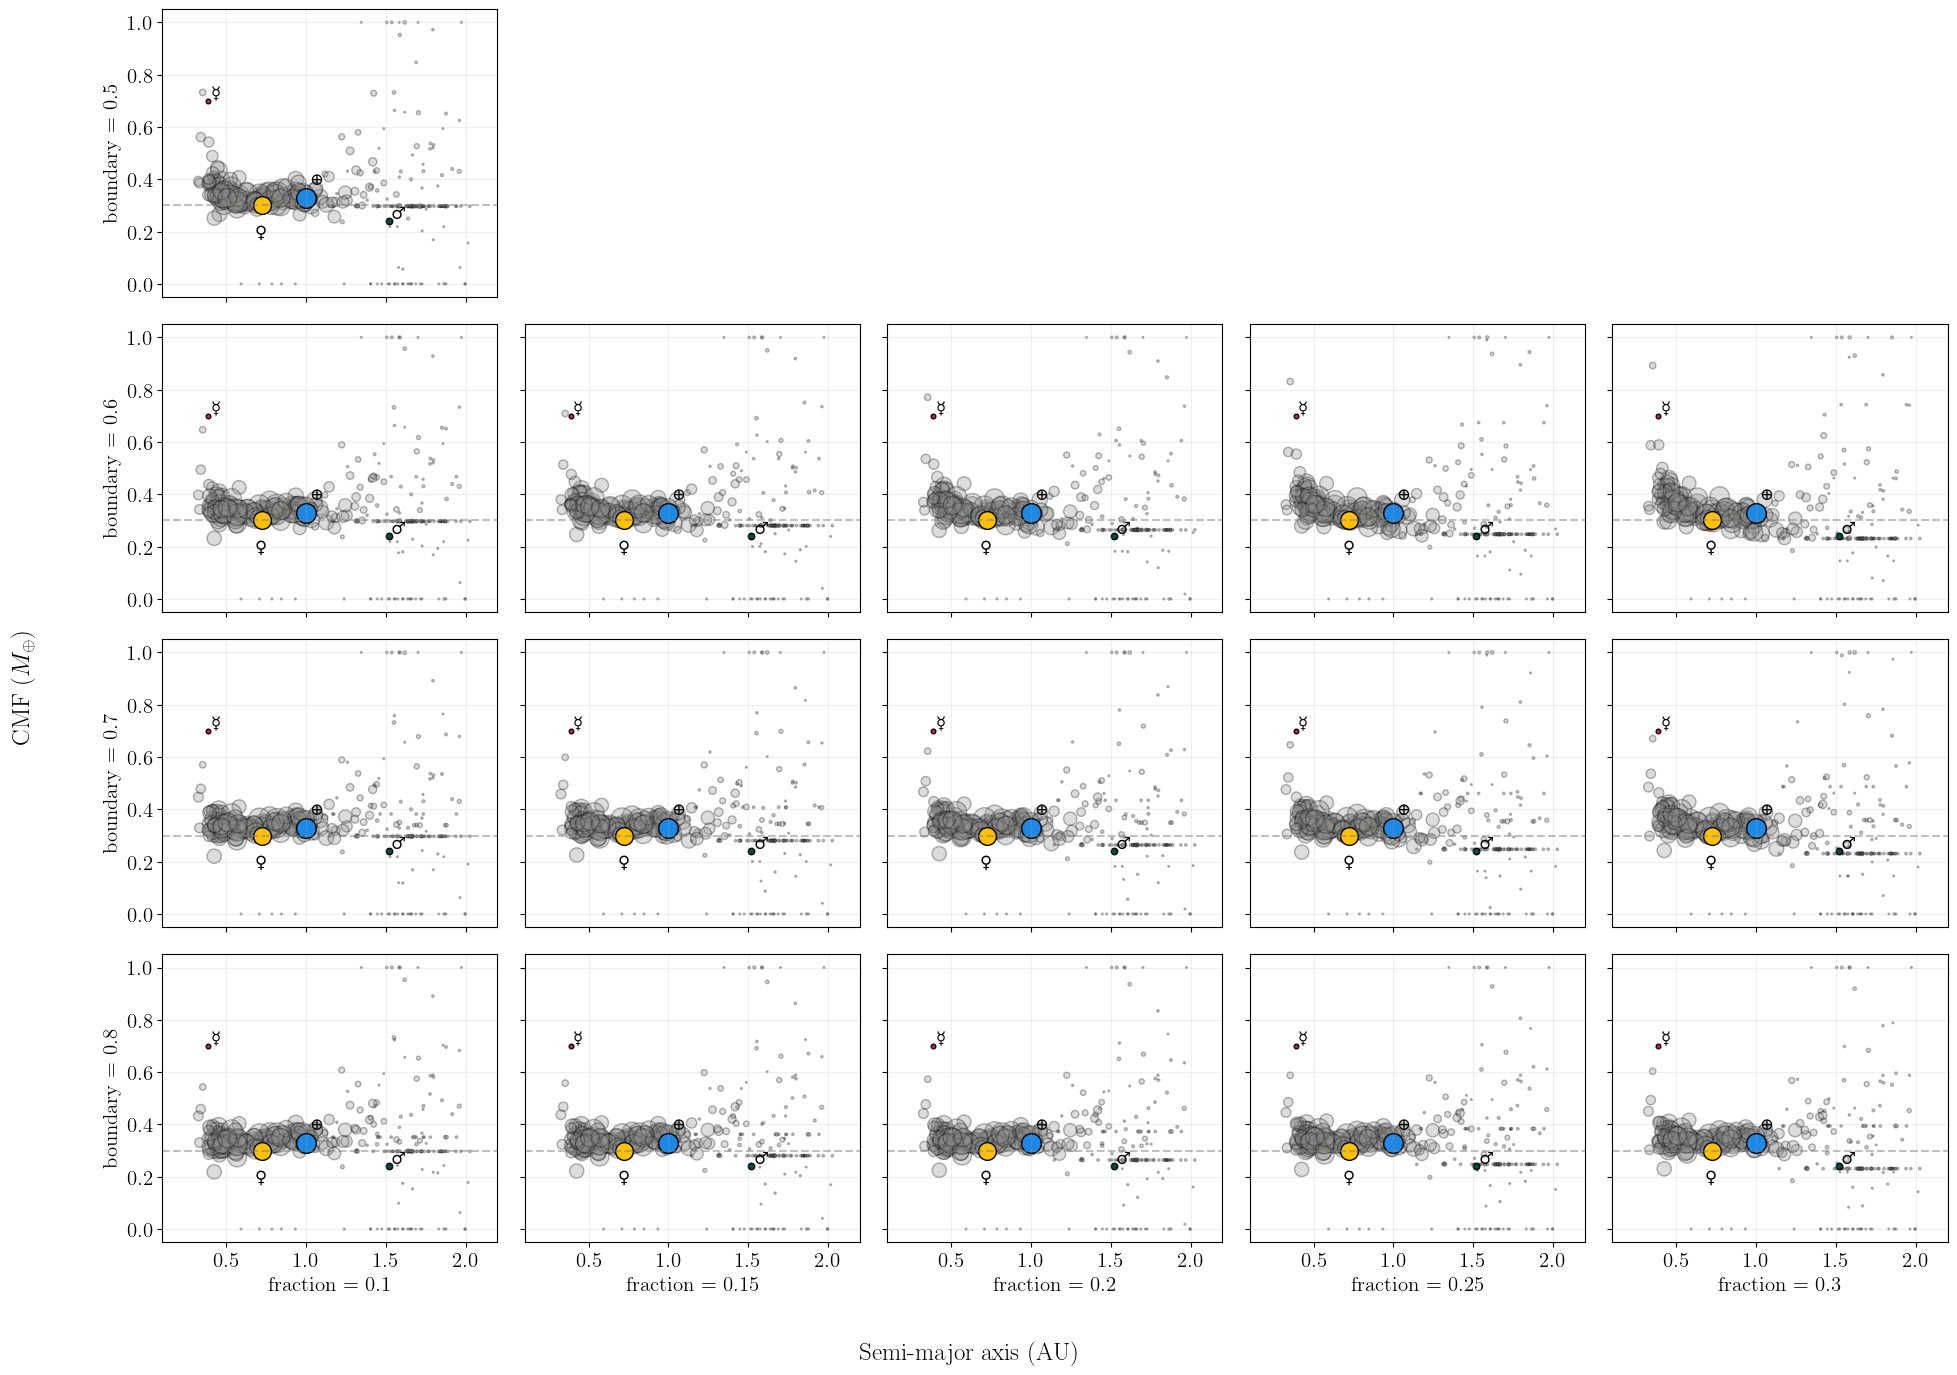

time = 3.00e+08 yrs


In [13]:
# Ensure these are sorted for consistent subplot layout
unique_bounds = sorted(ueda_v3_full_df['boundary'].unique())
unique_percs = sorted(ueda_v3_full_df['percentage'].unique())

dot_scale = 200

# Create grid of subplots
fig, axes = plt.subplots(len(unique_bounds), len(unique_percs),
                         figsize=(4 * len(unique_percs), 3.5 * len(unique_bounds)),
                         sharex=True, sharey=True)

# Loop through the grid
for i, bound in enumerate(unique_bounds):
    for j, perc in enumerate(unique_percs):
        ax = axes[i][j] if len(unique_bounds) > 1 else (axes[j] if len(unique_percs) > 1 else axes)
        
        # Filter for this combination
        df_subset = ueda_v3_full_df[(ueda_v3_full_df['boundary'] == bound) &
                                (ueda_v3_full_df['percentage'] == perc)]
        
        if not df_subset.empty:
            ax.scatter(df_subset['semi'], df_subset['cmf'],
                       s=df_subset['mass'] * sol_to_earth * 200,
                       alpha=0.3, color=colors[3], edgecolor = 'black')

            # Solar System references
            # Add Mercury & Earth
            ax.scatter(0.387, 0.7, color='#D81B60', edgecolors='black', linewidths=1, s= 0.055 * dot_scale, label = 'Mercury')
            ax.annotate('☿', [0.4, 0.71], fontsize=12, usetex=False)

            ax.scatter(0.723, 0.3, color='#FFC107', edgecolors='black', linewidths=1, s=0.815 * dot_scale, label = 'Venus')
            ax.annotate('♀', [0.68, 0.18], fontsize=12, usetex=False)

            ax.scatter(1, 0.33, color='#1E88E5', edgecolors='black', linewidths=1, s=dot_scale, label = 'Earth')
            ax.annotate('⊕', [1.02, 0.38], fontsize=12, usetex=False)

            ax.scatter(1.52, 0.24, color='#004D40', edgecolors='black', linewidths=1, s=0.107 * dot_scale, label = 'Mars')
            ax.annotate('♂', [1.53, 0.25], fontsize=12, usetex=False)

            # Reference lines
            ax.plot([0.1, 2.2], [0.3, 0.3], linestyle='dashed', color='grey', alpha=0.5)
        
            ax.set_xlim(0.1, 2.2)
            ax.grid(True, alpha = 0.2)
        
        else:
            ax.axis('off')  # No data: hide subplot
        
        # Axis labeling for clarity
        if i == len(unique_bounds) - 1:
            ax.set_xlabel(f"fraction = {perc}", fontsize=15)
        if j == 0:
            ax.set_ylabel(f"boundary = {bound}", fontsize=15)

# Shared axis labels
fig.text(0.5, 0.02, 'Semi-major axis (AU)', ha='center', fontsize=18)
fig.text(0.02, 0.5, r'CMF ($M_\oplus$)', va='center', rotation='vertical', fontsize=18)

# Global formatting
plt.tight_layout(rect=[0.05, 0.05, 1, 1])
#plt.suptitle("ueda_v3 Outputs by (bound, perc)", fontsize=14, y=1.02)
plt.show()

# Print time if defined
try:
    print(f"time = {cut_time:.2e} yrs")
except NameError:
    pass


fig.savefig("paper_plots/grid_ueda_v3_model1.pdf", dpi=300)

In [11]:
ueda_v3_full_df.to_csv("ueda_v3_grid_fulldf.csv")